In [32]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1" 
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import sys

from src.run_gsort_v2_wuericmod import *
import argparse
from scipy.io import loadmat
from itertools import product
import tqdm
import logging
import re

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ANALYSIS_BASE = '/Volumes/Analysis'
dataset = '2016-06-13-0'
vstim_datarun = 'kilosort_data000/data000'
estim_datarun = 'data001'
vstim_analysis_path = os.path.join(ANALYSIS_BASE, dataset, vstim_datarun)

print(vstim_analysis_path)
estim_analysis_path = os.path.join(ANALYSIS_BASE, dataset, estim_datarun)
pattern_path = os.path.join(estim_analysis_path, 'pattern_files')

vstim_data = vl.load_vision_data(vstim_analysis_path,
                                 vstim_datarun.rsplit('/')[-1],
                                 include_params=True,
                                 include_ei=True,
                                 include_noise=True,
                                 include_neurons=True)
noise = vstim_data.channel_noise
duplicates = compute_duplicates(vstim_data, noise)

/Volumes/Analysis/2016-06-13-0/kilosort_data000/data000


In [25]:
mutual_threshold = 0.5
compartments = ['soma', 'mixed']
cell_types = ['midget', 'parasol']
excluded_types = ['bad', 'dup']
start_time_limit = 0
end_time_limit = 55
pt = 1.5
time_limit = 55

In [37]:
total_electrode_list, total_cell_to_electrode_list, mutual_cells, array_id = get_cell_info(cell_types, vstim_data, compartments, noise, mutual_threshold=mutual_threshold)
            

In [50]:
cell = 96
k = 21
p = 74


In [51]:
electrode_list =  list(set([e for c in mutual_cells[cell] for e in total_cell_to_electrode_list[c]]))
cell_to_electrode_list = {k:v for k,v in total_cell_to_electrode_list.items() if k in mutual_cells[cell]}

try:
    signal = get_oldlabview_pp_data(estim_analysis_path , p, k)
except:
    print("Signal doesn't exists")

num_trials = len(signal)
raw_signal = signal[:, electrode_list, start_time_limit:end_time_limit].astype(float) 
mask =  get_mask(raw_signal)
cluster_cliques = cluster_each_cell(raw_signal,mask, cell_to_electrode_list, electrode_list, noise, "")
event_labels = convert_cliques_to_labels(cluster_cliques, num_trials)
significant_electrodes = np.arange(len(electrode_list))

data_on_cells = get_center_eis(cell, electrode_list, ap = (vstim_analysis_path[:-7], vstim_datarun.rsplit('/')[-1]), excluded_types = excluded_types, excluded_cells = list(duplicates), power_threshold=pt, array_id = array_id, sample_len_left = time_limit ,sample_len_right = time_limit)
            
finished, G, (_, _), (event_labels_with_virtual, _), (_, _), edge_to_matched_signals, _, mask, note = gsort_spike_sorting(event_labels, significant_electrodes, electrode_list, raw_signal, mask, 1, 1000, noise, data_on_cells, artifact_cluster_estimate=None )



total_p, cell_in_clusters = get_probabilities(G, event_labels_with_virtual)


In [52]:
total_p

Counter({96: 0.92, 73: 0.28, 45: 0.04, 63: 0.72})

{(0, 3): Text(0.11111111111111116, -0.3333333333333333, '96'),
 (2, 5): Text(-0.22222222222222224, 0.0, '73'),
 (2, 4): Text(0.0, 0.2222222222222222, '73'),
 (3, 2): Text(0.5555555555555556, -0.1111111111111111, '63'),
 (3, 1): Text(0.6666666666666666, 0.0, '45')}

<Figure size 432x288 with 0 Axes>

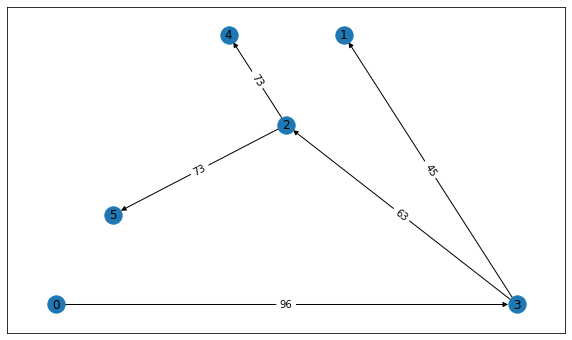

In [53]:
plt.figure()
fig, ax = plt.subplots(1,1,figsize = (10,6))
pos = nx.planar_layout(G)
nx.draw_networkx(G,pos, ax = ax)

edge_labels = nx.get_edge_attributes(G,'cell')
nx.draw_networkx_edge_labels(G, pos,  edge_labels)

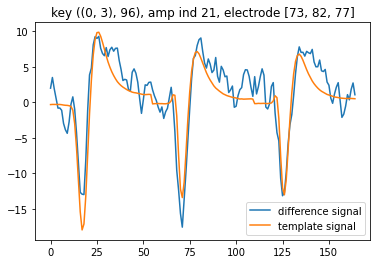

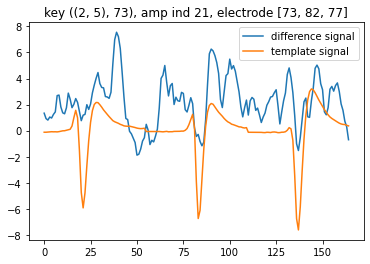

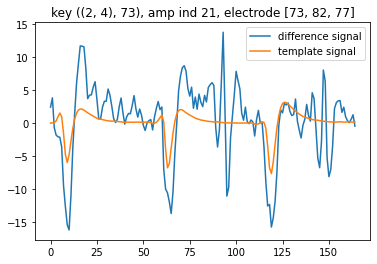

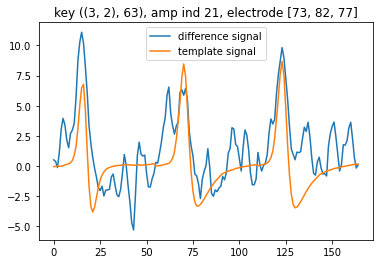

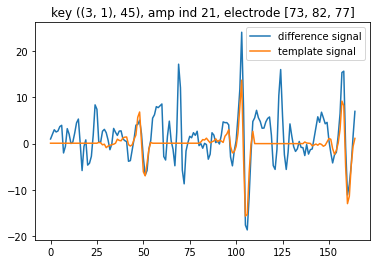

In [57]:

i = 2
j = 0



for key in list(edge_to_matched_signals.keys()):
    plt.figure()
    ax = plt.subplot(111)
    ax.plot( edge_to_matched_signals[key][0].flatten(), label ='difference signal')
    ax.plot( edge_to_matched_signals[key][1].flatten(), label ='template signal')

    ax.set_title("key %s, amp ind %s, electrode %s"%(key, k, electrode_list))
    ax.legend()

Text(0.5, 1.0, 'signal traces at 21, electrode 77')

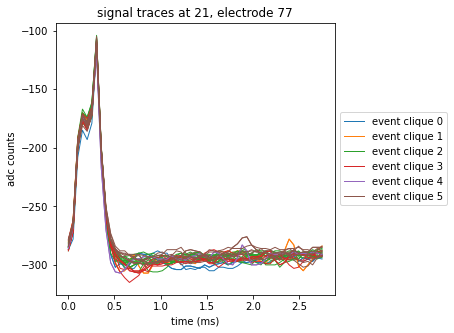

In [62]:
fig, ax = plt.subplots(1,1, figsize = (5, 5))
#ax.settitle("p %s e %s k %s" %(p, e, k))
j = 2
for i,l in enumerate(list(set(event_labels_with_virtual))):
    
    ax.plot(np.linspace(0, time_limit/20, time_limit), raw_signal[event_labels_with_virtual == l, :].reshape((-1, len(electrode_list)*time_limit))[0, j*time_limit:(j+1)*time_limit].T,linewidth=1, color = "C"+str(i%10), label = "event clique " + str(l));
    
    ax.plot(np.linspace(0, time_limit/20, time_limit), raw_signal[event_labels_with_virtual == l, :].reshape((-1, len(electrode_list)*time_limit))[:, j*time_limit:(j+1)*time_limit].T,linewidth=1, color = "C"+str(i%10));

    ax.set_xlabel("time (ms)")
    ax.set_ylabel("adc counts")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_ylim([-700, -200])
# A = 
ax.set_title("signal traces at %s, electrode %s" %(k, electrode_list[j]))